In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from transformers import AutoTokenizer, AutoModel

import warnings
warnings.filterwarnings(action='ignore')

In [42]:
labeled_df = pd.read_csv("/content/labeled_data_2.csv")
labeled_df = labeled_df[['Anchor','Random_Sentence','Label']]
labeled_df.head()

,Anchor,Random_Sentence,Label
0,Thousands of demonstrators have marched throug...,"He succeeds Lawrence Summers , another top eco...",0
1,Families of soldiers killed in the conflict jo...,Aigle Azur is just one of a number of airlines...,0
2,They marched from the Houses of Parliament to ...,At least one Kenyan was wounded Friday when pr...,1
3,"Police put the number of marchers at 10,000 wh...",WHO says they are receiving treatment and are ...,0
4,The protest comes on the eve of the annual con...,Indonesian police have arrested three men in c...,0


In [43]:
class SiameseDataset(Dataset):
    def __init__(self, Anchor, Random_Sentence, Label):
        self.text1 = Anchor
        self.text2 = Random_Sentence
        self.labels = Label

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text1 = self.text1[idx]
        text2 = self.text2[idx]
        label = self.labels[idx]
        return text1, text2, torch.tensor(label)

In [46]:
train_df, test_df = train_test_split(labeled_df, test_size=0.2, random_state=7)

train_dataset = SiameseDataset(train_df["Anchor"].tolist(), train_df["Random_Sentence"].tolist(), train_df["Label"].tolist())
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = SiameseDataset(test_df["Anchor"].tolist(), test_df["Random_Sentence"].tolist(), test_df["Label"].tolist())
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [47]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert/distilbert-base-uncased")

In [48]:
class SiameseNetwork(nn.Module):
    def __init__(self, base_model):
        super(SiameseNetwork, self).__init__()
        self.base_model = base_model

    def forward(self, inputs1, inputs2):
        outputs1 = self.base_model(**inputs1).last_hidden_state[:, 0, :].squeeze()
        outputs2 = self.base_model(**inputs2).last_hidden_state[:, 0, :].squeeze()
        return outputs1, outputs2

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, outputs1, outputs2, labels):
        euclidean_distance = F.pairwise_distance(outputs1, outputs2, keepdim=True)
        loss_contrastive = torch.mean((1 - labels) * torch.pow(euclidean_distance, 2) +
                                      (labels) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


siamese_model = SiameseNetwork(model)

In [49]:
siamese_model

SiameseNetwork(
  (base_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Li

In [50]:
optimizer = optim.Adam(siamese_model.parameters(), lr=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
siamese_model.to(device)
print(device)

criterion = ContrastiveLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 7

cuda


In [51]:
for epoch in range(num_epochs):
    total_loss = 0
    for text1, text2, labels in train_loader:

        inputs1 = tokenizer(text1, padding="max_length", truncation=True, max_length=276, return_tensors="pt")
        inputs2 = tokenizer(text2, padding="max_length", truncation=True, max_length=276, return_tensors="pt")

        inputs1 = inputs1.to(device)
        inputs2 = inputs2.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs1, outputs2 = siamese_model(inputs1, inputs2)
        loss = criterion(outputs1, outputs2, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}")

Epoch 1/7 - Average Loss: 3.9721
Epoch 2/7 - Average Loss: 0.4547
Epoch 3/7 - Average Loss: 0.3124
Epoch 4/7 - Average Loss: 0.2891
Epoch 5/7 - Average Loss: 0.2881
Epoch 6/7 - Average Loss: 0.2824
Epoch 7/7 - Average Loss: 0.2832


In [55]:
siamese_model.eval()
predictions = []

with torch.no_grad():
    for text1, text2, labels in test_loader:

        inputs1 = tokenizer(text1, padding="max_length", truncation=True, max_length=276, return_tensors="pt")
        inputs2 = tokenizer(text2, padding="max_length", truncation=True, max_length=276, return_tensors="pt")

        inputs1 = inputs1.to(device)
        inputs2 = inputs2.to(device)

        outputs1, outputs2 = siamese_model(inputs1, inputs2)
        distances = torch.nn.functional.pairwise_distance(outputs1, outputs2)
        predictions.extend(distances.cpu().numpy())

In [56]:
test_df['predicted_labels'] = predictions
print(test_df[test_df['Label']==1]['predicted_labels'].mean(), test_df[test_df['Label']==0]['predicted_labels'].mean())

0.55165476 0.681791


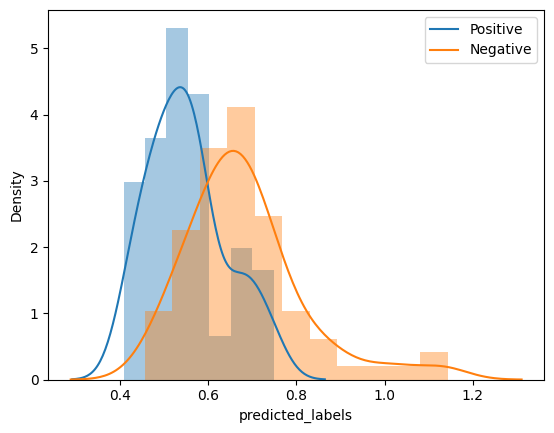

In [57]:
sns.distplot(test_df[test_df['Label']==1]['predicted_labels'])
sns.distplot(test_df[test_df['Label']==0]['predicted_labels'])
plt.legend(['Positive', 'Negative'])
plt.show()

In [58]:
def calculate_gini_coefficient(predictions):
    predictions = np.array(predictions)
    n = predictions.size
    lorenz_curve = np.cumsum(np.sort(predictions)) / predictions.sum()
    lorenz_curve = np.insert(lorenz_curve, 0, 0)
    gini_index = 1 - 2 * np.trapz(lorenz_curve, np.linspace(0, 1, n+1))
    return gini_index

In [59]:
Pretrained  = np.array(test_df['predicted_labels'])
gini = calculate_gini_coefficient(Pretrained)
print('Using Pretrained Bert:', gini)

Using Pretrained Bert: 0.1132423464741027
